In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("clean.csv")
df.head()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH3,DMDBORN4,DMDEDUC2,INDFMPIR,DR1TKCAL,DR1TPROT,DR1TCARB,...,PAQ665,RXDUSE,RXDDRUG,RXDDRGID,RXDRSC1,BPQ020,DIQ010,DBQ700,DBQ197,HIQ011
0,109290.0,2.0,68.0,4.0,1.0,5.0,5.0,822.0,30.45,143.44,...,1.0,1.0,ATORVASTATIN,d04105,E78.0,1.0,1.0,3.0,2.0,1.0
1,109290.0,2.0,68.0,4.0,1.0,5.0,5.0,822.0,30.45,143.44,...,1.0,1.0,EMPAGLIFLOZIN,d08275,R73,1.0,1.0,3.0,2.0,1.0
2,109290.0,2.0,68.0,4.0,1.0,5.0,5.0,822.0,30.45,143.44,...,1.0,1.0,METFORMIN,d03807,R73,1.0,1.0,3.0,2.0,1.0
3,109290.0,2.0,68.0,4.0,1.0,5.0,5.0,822.0,30.45,143.44,...,1.0,1.0,METOPROLOL,d00134,I10,1.0,1.0,3.0,2.0,1.0
4,109300.0,2.0,54.0,6.0,2.0,5.0,5.0,719.0,27.71,86.45,...,2.0,2.0,NONE,NONE,NONE,2.0,2.0,2.0,2.0,1.0


In [3]:
df.columns

Index(['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDBORN4', 'DMDEDUC2',
       'INDFMPIR', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE',
       'DR1TTFAT', 'DR1TSFAT', 'DR1TCHOL', 'DR1TALCO', 'DR1TCAFF', 'DR1TSODI',
       'DR1TPOTA', 'DR2TKCAL', 'DR2TPROT', 'DR2TCARB', 'DR2TSUGR', 'DR2TFIBE',
       'DR2TTFAT', 'DR2TSFAT', 'DR2TCHOL', 'DR2TALCO', 'DR2TCAFF', 'DR2TSODI',
       'DR2TPOTA', 'BPXOSY1', 'BPXODI1', 'BPXOSY2', 'BPXODI2', 'BPXOSY3',
       'BPXODI3', 'BPXOPLS1', 'BPXOPLS2', 'BPXOPLS3', 'BMXWT', 'BMXHT',
       'BMXBMI', 'BMXWAIST', 'LBXIN', 'LBXGLU', 'LBXTR', 'LBDLDL', 'LBDHDD',
       'LBXHSCRP', 'PHAFSTHR', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650',
       'PAQ665', 'RXDUSE', 'RXDDRUG', 'RXDDRGID', 'RXDRSC1', 'BPQ020',
       'DIQ010', 'DBQ700', 'DBQ197', 'HIQ011'],
      dtype='object')

In [4]:
columns_to_drop = [
    # Day 1 dietary variables
    'DR1TPROT', 'DR1TCARB', 'DR1TCHOL', 'DR1TALCO',
    'DR1TCAFF', 'DR1TSODI', 'DR1TPOTA',
    
    # Day 2 dietary variables
    'DR2TPROT', 'DR2TCARB', 'DR2TCHOL', 'DR2TALCO', 
    'DR2TCAFF', 'DR2TSODI', 'DR2TPOTA',
    
    # Weight and height
    'BMXWT', 'BMXHT',

    # Blood pressure pulse readings
    'BPXOPLS1', 'BPXOPLS2', 'BPXOPLS3',

    # Drug metadata
    'RXDDRGID', 'RXDRSC1',

    'SEQN', 'LBDLDL', 'RIDAGEYR', 'RIDRETH3', 'DMDBORN4', 'DMDEDUC2', 'PHAFSTHR',
    'PAQ665', 'BPQ020', 'DIQ010', 'HIQ011'
]
df.drop(columns=columns_to_drop, inplace=True)

# Feature Engineering
### Clinical Risk Indicators (Metabolic Syndrome Flags)

In [5]:
# Obesity based on waist circumference (gender-specific)
df['flag_obese'] = ((df['RIAGENDR'] == 1) & (df['BMXWAIST'] > 102)) | \
                   ((df['RIAGENDR'] == 2) & (df['BMXWAIST'] > 88))

# Elevated blood pressure
df['avg_sys'] = df[['BPXOSY1', 'BPXOSY2', 'BPXOSY3']].mean(axis=1)
df['avg_dia'] = df[['BPXODI1', 'BPXODI2', 'BPXODI3']].mean(axis=1)
df['flag_high_bp'] = (df['avg_sys'] >= 130) | (df['avg_dia'] >= 85)

# Elevated fasting glucose
df['flag_high_glucose'] = df['LBXGLU'] >= 100

# Elevated triglycerides
df['flag_high_triglycerides'] = df['LBXTR'] >= 150

# Low HDL cholesterol (gender-specific)
df['flag_low_hdl'] = ((df['RIAGENDR'] == 1) & (df['LBDHDD'] < 40)) | \
                     ((df['RIAGENDR'] == 2) & (df['LBDHDD'] < 50))

# HOMA-IR
df['HOMA_IR'] = (df['LBXIN'] * df['LBXGLU']) / 405
df['flag_homa_ir'] = df['HOMA_IR'] > 2.5  

### Derived Metabolic Syndrome Target

In [6]:
df['met_syndrome_count'] = df[['flag_obese', 'flag_high_bp', 'flag_high_glucose',
                               'flag_high_triglycerides', 'flag_low_hdl', 'flag_homa_ir']].sum(axis=1)
df['has_metabolic_syndrome'] = df['met_syndrome_count'] >= 3

### Lifestyle Feature Engineering

In [7]:
# Average Daily Intake
df['avg_kcal'] = df[['DR1TKCAL', 'DR2TKCAL']].mean(axis=1)
df['avg_sugar'] = df[['DR1TSUGR', 'DR2TSUGR']].mean(axis=1)
df['avg_fat'] = df[['DR1TTFAT', 'DR2TTFAT']].mean(axis=1)
df['avg_fiber'] = df[['DR1TFIBE', 'DR2TFIBE']].mean(axis=1)

# Change in Intake
df['delta_kcal'] = df['DR2TKCAL'] - df['DR1TKCAL']
df['delta_sugar'] = df['DR2TSUGR'] - df['DR1TSUGR']
df['delta_fat'] = df['DR2TTFAT'] - df['DR1TTFAT']

# Binary Flags for Intake Reduction
df['reduced_calories'] = df['delta_kcal'] < -100
df['reduced_sugar'] = df['delta_sugar'] < -10

# Likely Dieting (Overweight + trying to lose weight + reduced intake)
df['likely_dieting'] = (
    (df['BMXBMI'] >= 25) &
    df['reduced_calories'] &
    df['DBQ700'].eq(1)
)

# Eating Out Behavior
df['eats_out_often'] = df['DBQ197'].isin([1, 2])  # every day / most days
df['eats_out_rarely'] = df['DBQ197'].isin([4, 5])  # 1–2x/week or never

# Physical Activity
df['physically_active'] = (
    df[['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650']].isin([1]).any(axis=1)
)
df['activity_score'] = df[['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650']].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1)

# Lifestyle Effort Score
df['lifestyle_effort'] = (
    df['likely_dieting'].astype(int)
    + df['eats_out_rarely'].astype(int)
    + df['delta_kcal'].apply(lambda x: 1 if x < 0 else 0)  # decreased calories
    + df['delta_sugar'].apply(lambda x: 1 if x < 0 else 0)  # decreased sugar
    + df['physically_active'].astype(int)  # NEW: physical activity
)

/var/folders/z1/w_njtpr52ss65yn2_5wp9xfm0000gn/T/ipykernel_21746/814351403.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df['activity_score'] = df[['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650']].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1)


### Med_Class Variable

In [8]:
met_syn_drugs = [
    # Diabetes-related
    'METFORMIN', 'INSULIN', 'GLIPIZIDE', 'GLYBURIDE', 'PIOGLITAZONE', 'SITAGLIPTIN',
    'EMPAGLIFLOZIN', 'DAPAGLIFLOZIN', 'CANAGLIFLOZIN', 'LINAGLIPTIN', 'LIRAGLUTIDE',
    'EXENATIDE', 'SEMAGLUTIDE', 'GLIMEPIRIDE',

    # Hypertension
    'LISINOPRIL', 'LOSARTAN', 'AMLODIPINE', 'METOPROLOL', 'RAMIPRIL', 'FUROSEMIDE',
    'HYDROCHLOROTHIAZIDE', 'VALSARTAN', 'BISOPROLOL', 'SPIRONOLACTONE', 'DILTIAZEM',

    # Cholesterol
    'ATORVASTATIN', 'ROSUVASTATIN', 'SIMVASTATIN', 'PRAVASTATIN', 'PITAVASTATIN',
    'EZETIMIBE', 'FENOFIBRATE', 'GEMFIBROZIL', 'FENOFIBRIC ACID', 'NIACIN',
]

# Clean and classify each record
def classify_meds(drug_str):
    if pd.isna(drug_str) or drug_str.strip().upper() in ['NONE', 'NO MEDICATION', '']:
        return 'None'

    # Clean and split into list
    drugs = [d.strip().upper() for d in drug_str.split(';')]
    
    has_met_syn = any(any(med in drug for med in met_syn_drugs) for drug in drugs)
    has_non_met_syn = any(not any(med in drug for med in met_syn_drugs) for drug in drugs)

    if has_met_syn and has_non_met_syn:
        return 'Both MetSyn + Other'
    elif has_met_syn:
        return 'MetSyn-related'
    elif has_non_met_syn:
        return 'Other'
    else:
        return 'None'

# Apply to your column
df['med_class'] = df['RXDDRUG'].astype(str).apply(classify_meds)

In [9]:
# 1 corresponds to using medication
# 2 corresponds to not using medication

In [10]:
df.columns

Index(['RIAGENDR', 'INDFMPIR', 'DR1TKCAL', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT',
       'DR1TSFAT', 'DR2TKCAL', 'DR2TSUGR', 'DR2TFIBE', 'DR2TTFAT', 'DR2TSFAT',
       'BPXOSY1', 'BPXODI1', 'BPXOSY2', 'BPXODI2', 'BPXOSY3', 'BPXODI3',
       'BMXBMI', 'BMXWAIST', 'LBXIN', 'LBXGLU', 'LBXTR', 'LBDHDD', 'LBXHSCRP',
       'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'RXDUSE', 'RXDDRUG', 'DBQ700',
       'DBQ197', 'flag_obese', 'avg_sys', 'avg_dia', 'flag_high_bp',
       'flag_high_glucose', 'flag_high_triglycerides', 'flag_low_hdl',
       'HOMA_IR', 'flag_homa_ir', 'met_syndrome_count',
       'has_metabolic_syndrome', 'avg_kcal', 'avg_sugar', 'avg_fat',
       'avg_fiber', 'delta_kcal', 'delta_sugar', 'delta_fat',
       'reduced_calories', 'reduced_sugar', 'likely_dieting', 'eats_out_often',
       'eats_out_rarely', 'physically_active', 'activity_score',
       'lifestyle_effort', 'med_class'],
      dtype='object')

In [11]:
# variables to include in the model
predictors = [
    # Lifestyle and Behavior
    'avg_kcal', 'avg_sugar', 'avg_fat', 'avg_fiber',
    'reduced_calories', 'reduced_sugar', 'likely_dieting',
    'eats_out_often', 'eats_out_rarely',
    'physically_active', 'lifestyle_effort',

    # Medication
    'med_class'
]

# Demographics: RIAGENDR, RIDAGEYR, RIDRETH3, DMDEDUC2, INDFMPIR
# Questionnaire: PHAFSTHR, PAQ665, BPQ020, DIQ010, DBQ700, DBQ197, HIQ011

# EDA

### Do people on meds show differences in effort or health outcomes compared to those not on meds?

In [12]:
df.groupby('med_class')[['lifestyle_effort', 'activity_score', 'likely_dieting']].mean()

,lifestyle_effort,activity_score,likely_dieting
med_class,,,
Both MetSyn + Other,1.804878,1.048780,0.073171
MetSyn-related,1.728976,0.928880,0.011533
None,1.904219,1.405929,0.023945
Other,1.775388,0.958241,0.013603


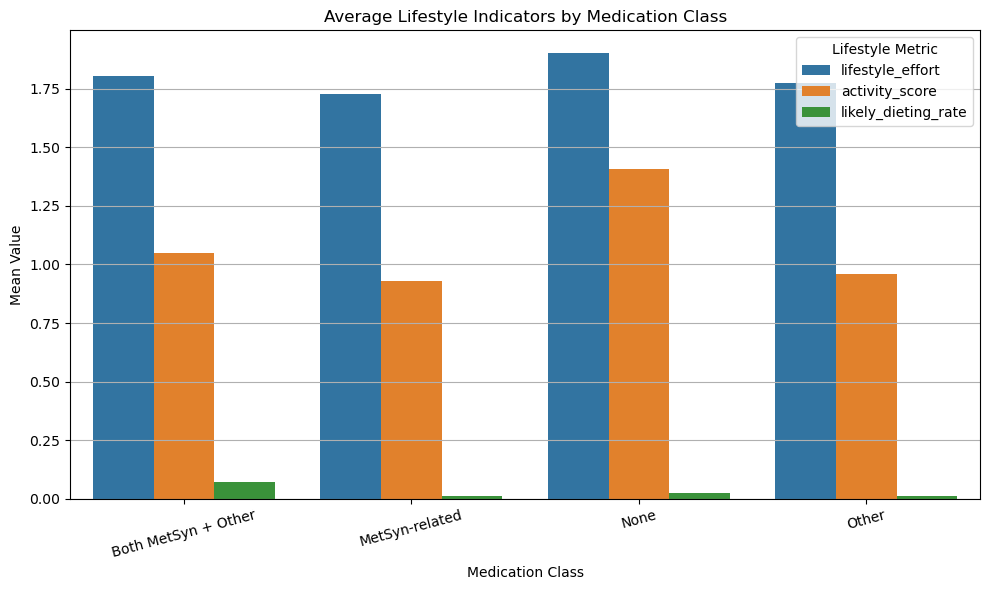

In [13]:
df['likely_dieting_numeric'] = df['likely_dieting'].astype(int)
# Calculate means grouped by medication class
grouped_means = df.groupby('med_class')[['lifestyle_effort', 'activity_score', 'likely_dieting_numeric']].mean().reset_index()
grouped_means = grouped_means.rename(columns={'likely_dieting_numeric': 'likely_dieting_rate'})
# Melt for plotting
melted = pd.melt(grouped_means, id_vars='med_class', var_name='Metric', value_name='Mean Value')
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='med_class', y='Mean Value', hue='Metric')
plt.title('Average Lifestyle Indicators by Medication Class')
plt.ylabel('Mean Value')
plt.xlabel('Medication Class')
plt.xticks(rotation=15)
plt.tight_layout()
plt.legend(title='Lifestyle Metric')
plt.grid(axis='y')
plt.show()

Those who don't take medication have slightly higher lifestyle_effort and activity_score, but other than that the values for lifestyle_effort, activity_score, and likely_dieting_rate are generally around the same. Overall however, the averages for all of these are quite low, the highest average of lifestyle_effort is slightly over 1.75 and for those who aren't taking medicine, same for activity_score is between 1.25 and 1.50, which is also for those who aren't taking medicine. Then the highest average for likely_dieting_rate is well under 0.25 and it is for those who are taking medicine for metabolic syndrome and other.

### Who is healthy without medication?

In [14]:
# Number of people not taking medication and are healthy
df[(df['med_class'] == 'None') & (df['has_metabolic_syndrome'] == False)].shape

(528, 61)

In [15]:
# Number of people not taking medication and are healthy
df[(df['med_class'] == 'None') & (df['has_metabolic_syndrome'] == True)].shape

(349, 61)

In [16]:
# Number of people taking medication and are not healthy
df[(df['med_class'] == 'MetSyn-related') & (df['has_metabolic_syndrome'] == True)].shape

(1561, 61)

In [17]:
df[(df['med_class'] == 'MetSyn-related') & (df['has_metabolic_syndrome'] == False)].shape

(520, 61)

### Metabolic syndrome vs med_class

In [18]:
df.groupby('med_class')['has_metabolic_syndrome'].value_counts(normalize=True)

med_class            has_metabolic_syndrome
Both MetSyn + Other  True                      0.780488
                     False                     0.219512
MetSyn-related       True                      0.750120
                     False                     0.249880
None                 False                     0.602052
                     True                      0.397948
Other                True                      0.632395
                     False                     0.367605
Name: proportion, dtype: float64

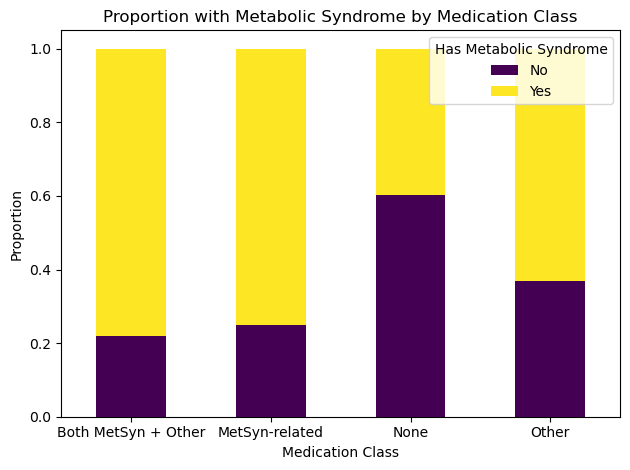

In [19]:
# Get normalized proportions
met_syn_dist = df.groupby('med_class')['has_metabolic_syndrome'].value_counts(normalize=True).unstack()

# Plot as stacked bar
met_syn_dist.plot(kind='bar', stacked=True, colormap='viridis')

plt.title('Proportion with Metabolic Syndrome by Medication Class')
plt.ylabel('Proportion')
plt.xlabel('Medication Class')
plt.legend(title='Has Metabolic Syndrome', labels=['No', 'Yes'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

the None medication class has the lowest proportion for those who have metabolic syndrome and the highest proportion for those who don't have metabolic syndrome. For the rest who do take any kind of medication, it shows that they are all similiar in that only 1/3 at the most don't have metabolic syndrome, and that the rest of the proportion do. 

### Does med_class improve prediction?

This project explores how well lifestyle and behavior predict metabolic syndrome in comparison to models that also include medication use. While medication is usually prescribed after diagnosis, and thus expected to correlate with the presence of metabolic syndrome, our goal is to understand its added predictive value. Through exploratory analysis and predictive modeling, we examine whether individuals on medications differ in their health outcomes and efforts compared to those who are not. Ultimately, we assess whether lifestyle-based indicators alone are strong enough for predictive modeling, reinforcing prevention-focused strategies.

/var/folders/z1/w_njtpr52ss65yn2_5wp9xfm0000gn/T/ipykernel_21746/2994981896.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lifestyle_met_syn = df.groupby('lifestyle_bin')['has_metabolic_syndrome'].value_counts(normalize=True).unstack()


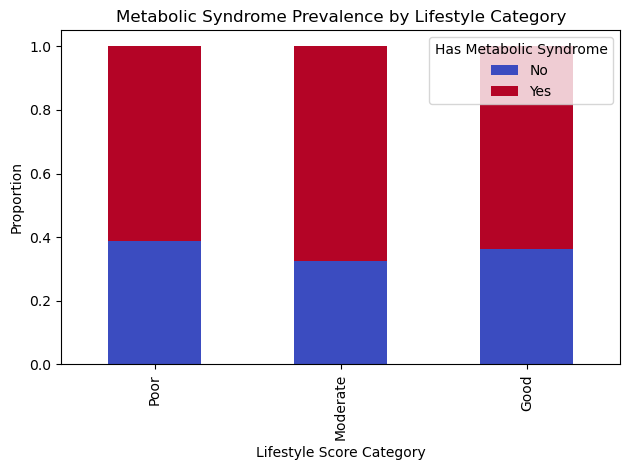

In [20]:
# Bin lifestyle_effort
df['lifestyle_bin'] = pd.cut(df['lifestyle_effort'],
                             bins=[-0.1, 1, 2, df['lifestyle_effort'].max()],
                             labels=['Poor', 'Moderate', 'Good'])

# Group and normalize
lifestyle_met_syn = df.groupby('lifestyle_bin')['has_metabolic_syndrome'].value_counts(normalize=True).unstack()

# Plot
lifestyle_met_syn.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Metabolic Syndrome Prevalence by Lifestyle Category')
plt.ylabel('Proportion')
plt.xlabel('Lifestyle Score Category')
plt.legend(title='Has Metabolic Syndrome', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

Surprisingly, the proportions generally seem the same, about 40% or slightly less of those with poor, moderate, or good lifestyles don't have metabolic syndrome, and the rest do.

/var/folders/z1/w_njtpr52ss65yn2_5wp9xfm0000gn/T/ipykernel_21746/3630438039.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_met_syn = df.groupby('income_level')['has_metabolic_syndrome'].value_counts(normalize=True).unstack()


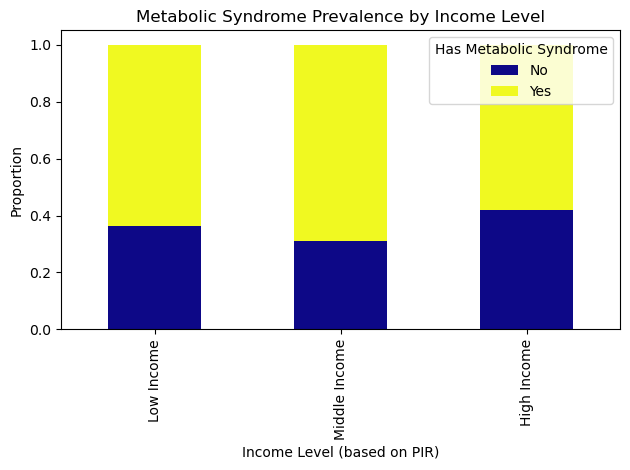

In [21]:
# Create income bins
df['income_level'] = pd.cut(df['INDFMPIR'],
                            bins=[-0.1, 1.3, 3.5, df['INDFMPIR'].max()],
                            labels=['Low Income', 'Middle Income', 'High Income'])

# Group and normalize
income_met_syn = df.groupby('income_level')['has_metabolic_syndrome'].value_counts(normalize=True).unstack()

# Plot
income_met_syn.plot(kind='bar', stacked=True, colormap='plasma')
plt.title('Metabolic Syndrome Prevalence by Income Level')
plt.ylabel('Proportion')
plt.xlabel('Income Level (based on PIR)')
plt.legend(title='Has Metabolic Syndrome', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

The same pattern is noticed across income levels, 40% or less of the proportion doesn't have metabolic syndrome while the rest do, and this is for low, middle, and high income individuals.

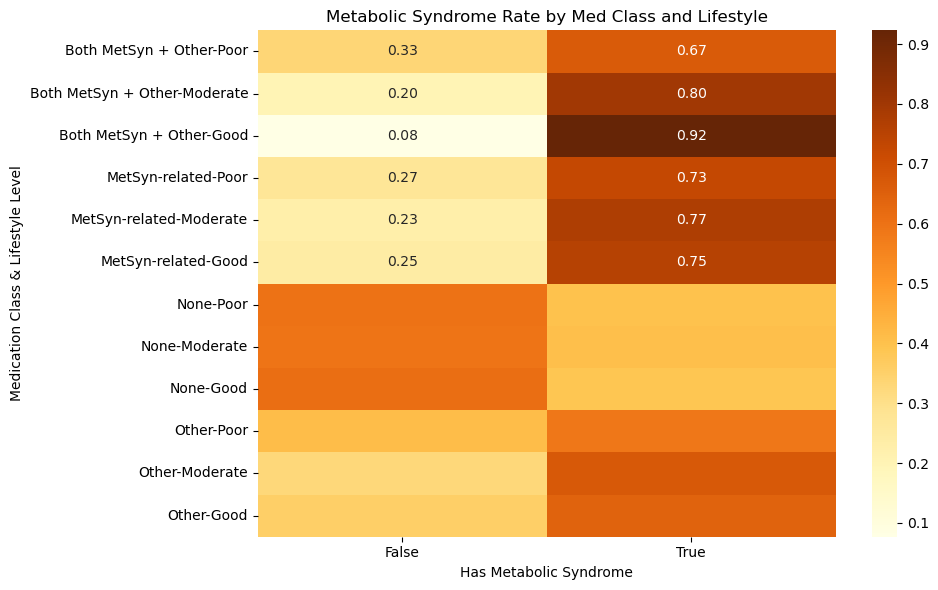

In [22]:
# Cross-tab counts
cross_tab = pd.crosstab([df['med_class'], df['lifestyle_bin']],
                        df['has_metabolic_syndrome'],
                        normalize='index')

# Plot as heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='YlOrBr')
plt.title('Metabolic Syndrome Rate by Med Class and Lifestyle')
plt.xlabel('Has Metabolic Syndrome')
plt.ylabel('Medication Class & Lifestyle Level')
plt.tight_layout()
plt.show()

the cross tab is pretty much a mix of the previous plots and has simlar results

Does med_class improve prediction?

In [23]:
df

,RIAGENDR,INDFMPIR,DR1TKCAL,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR2TKCAL,DR2TSUGR,DR2TFIBE,...,likely_dieting,eats_out_often,eats_out_rarely,physically_active,activity_score,lifestyle_effort,med_class,likely_dieting_numeric,lifestyle_bin,income_level
0,2.0,5.0,822.0,53.80,9.7,13.77,4.802,1844.0,54.92,10.9,...,False,True,False,True,2,1,MetSyn-related,0,Poor,High Income
1,2.0,5.0,822.0,53.80,9.7,13.77,4.802,1844.0,54.92,10.9,...,False,True,False,True,2,1,MetSyn-related,0,Poor,High Income
2,2.0,5.0,822.0,53.80,9.7,13.77,4.802,1844.0,54.92,10.9,...,False,True,False,True,2,1,MetSyn-related,0,Poor,High Income
3,2.0,5.0,822.0,53.80,9.7,13.77,4.802,1844.0,54.92,10.9,...,False,True,False,True,2,1,MetSyn-related,0,Poor,High Income
4,2.0,5.0,719.0,29.81,6.8,30.44,11.448,850.0,32.53,6.5,...,False,True,False,False,0,0,None,0,Poor,High Income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155,2.0,5.0,2639.0,83.04,14.9,123.59,35.286,1305.0,58.49,10.2,...,False,True,False,False,0,2,Other,0,Moderate,High Income
6156,2.0,5.0,2639.0,83.04,14.9,123.59,35.286,1305.0,58.49,10.2,...,False,True,False,False,0,2,Other,0,Moderate,High Income
6157,2.0,5.0,2639.0,83.04,14.9,123.59,35.286,1305.0,58.49,10.2,...,False,True,False,False,0,2,Other,0,Moderate,High Income
6158,1.0,2.0,1537.0,113.83,10.7,63.40,17.630,2030.0,160.16,6.2,...,False,False,False,True,1,1,Other,0,Poor,Middle Income


In [24]:
y = df['has_metabolic_syndrome']
X = df.drop(columns=['has_metabolic_syndrome'])


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [26]:
X_train_numeric = X_train.select_dtypes(include='number')
X_test_numeric = X_test.select_dtypes(include='number')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)



In [27]:
X_train.select_dtypes(include='number')


,RIAGENDR,INDFMPIR,DR1TKCAL,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR2TKCAL,DR2TSUGR,DR2TFIBE,...,avg_kcal,avg_sugar,avg_fat,avg_fiber,delta_kcal,delta_sugar,delta_fat,activity_score,lifestyle_effort,likely_dieting_numeric
2391,2.0,1.48,2374.0,126.18,19.9,100.59,24.893,1565.0,94.24,21.3,...,1969.5,110.210,82.990,20.60,-809.0,-31.94,-35.20,0,2,0
1208,2.0,5.00,1910.0,53.94,18.8,121.13,28.924,809.0,64.18,6.7,...,1359.5,59.060,76.950,12.75,-1101.0,10.24,-88.36,0,1,0
5753,2.0,2.63,2878.0,131.95,24.1,143.84,49.743,2906.0,148.98,52.4,...,2892.0,140.465,132.285,38.25,28.0,17.03,-23.11,1,1,0
2501,1.0,1.96,1466.0,164.15,11.4,41.72,11.605,1524.0,147.41,4.9,...,1495.0,155.780,48.385,8.15,58.0,-16.74,13.33,0,1,0
3193,1.0,0.65,1439.0,99.45,2.3,35.07,14.623,2472.0,25.60,5.6,...,1955.5,62.525,85.915,3.95,1033.0,-73.85,101.69,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,1.0,5.00,2411.0,77.05,12.8,124.24,40.513,1763.0,51.48,11.3,...,2087.0,64.265,107.835,12.05,-648.0,-25.57,-32.81,1,3,0
3294,2.0,4.00,2206.0,84.47,15.7,103.25,28.346,1270.0,52.72,18.2,...,1738.0,68.595,77.110,16.95,-936.0,-31.75,-52.28,2,3,0
4317,2.0,1.97,1229.0,40.91,17.0,64.55,11.883,1123.0,22.17,8.8,...,1176.0,31.540,55.425,12.90,-106.0,-18.74,-18.25,1,3,0
5074,1.0,5.00,1239.0,47.47,8.3,34.57,9.599,976.0,7.36,12.0,...,1107.5,27.415,36.250,10.15,-263.0,-40.11,3.36,3,3,0


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the model
logreg = LogisticRegression(max_iter=100, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Confusion Matrix:
 [[444   0]
 [  0 788]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       444
        True       1.00      1.00      1.00       788

    accuracy                           1.00      1232
   macro avg       1.00      1.00      1.00      1232
weighted avg       1.00      1.00      1.00      1232

